# Unit 4 Project: Using Hierarchies to Account for Dependence Between Groups

**Task**:

Two parts:

1. Propose a data set that's compatible with a hierarchical model structure built with pymc, and that potentially has some dependence between subgroups within the data set. I must approve your submission before you move on to part 2.

2. Create, analyze, and present a model using pymc within the colab environment, on a data set of your choice, with the following restrictions
- You must have at least one piror and at least one hyperprior.
- Your model must have at least one seperate prior for each subgroup of the data set, and a at least one shared hyperior for all the groups.
- Any student may use the following data set: [basketball2324](https://github.com/thedarredondo/data-science-fundamentals/blob/main/Data/basketball2324.csv). I recommend trying to model TRB (total rebounds) by player position (pos). Also, I recommend pandas query function to splice and clean the data.



Guidlines:

- You are allowed to copy and paste any code from the notes, including my answer key (AK), without any reference or citations. Same goes for the course textbook, BAP3.

- This is an individual project. It is fine if you model the same process as a peer, but your raw data **must** be substantially different. "Substantially different" means that I, your instructor, arbitrarily think your data sets are different enough. There is an execption to this rule for unit 4: [NBA player data from the 2023-2024 season](https://github.com/thedarredondo/data-science-fundamentals/blob/main/Data/basketball2324.csv). Other seasons are allowed as well.

- Do not look at other student's code/jupyter notebooks. Copying, or copying and pasting, other students code will result in a failing grade. Also, I will tell all the other teachers I know that you cheated.

- If you want to know what another student did, ask them--any verbal communication about a project is allowed and encouraged. If you want to see a graphic they made, ask them to sketch a picture of it for you by hand.

- Any handwritten communication is also allowed and encouraged, so long as all parties are in the same physical location together. Example: you may sketch out a piece of code while verbally explaining to someone what you did. Do NOT: hand write the code for your entire project, take a picture, and send it to everyone in the course.

- If you use someone's code from outside this course (like from the internet, an AI, or your parent), you must ask me if it is ok, and you must cite them in your work. I don't care all they did was to click your space bar one more time: you tell me, and you cite their contribution. You don't need to tell me about or cite verbal or handwritten communication though.

- You may use a more complicated model--like something from further along in the course--IF I give you permission.

- If you are unsure whether or not something is ok or allowed: ASK BEFORE YOU DO IT.

Faliure to adhere to these guidlines will result in a failing grade.

Tips:

- Try to pick something that you care about, have knowledge of, experience with, or that you find interesting/cool.

- Gather data *before* picking a likelihood.

-  Use your best idea now; maybe you can look at the context you used in the previous project, and gather different data from it.

- All students are allowed to use this data set: [NBA player data from the 2023-2024 season](https://github.com/thedarredondo/data-science-fundamentals/blob/main/Data/basketball2324.csv). Why? This is could lead to similar analysis as the soccer data analysis--basically, I think this data set will work well with the models we ran in class. Let me know if you have questions about downloading and cleaning the data.

- Comment heavily, and explain your steps and thought process with text blocks. This is not only requried, it'll also help you understand what you're doing and what you want to do.

- Want an example? The Unit4NotesAK *is* your example! You are expected to be somewhere between a half and three-quarters as detailed--but more is always welcome.

- I didn't totally understand the chemical shift context--which means you don't have to totally understand the context of your data either! You should try to learn as you go, though.


In [29]:

import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import pymc as pm

# Introduction

In the NBA, freethrows are 1-point shots a player makes if they are fouled while attempting a field goal. These shots are good ways of measuring player productivity as fundementals are important in excelling at basketball. For this project, I will be using a heirarchical model to measure what player out of the sample of 573 has the most free throws (FT)

In [30]:

url="https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/refs/heads/main/Data/basketball2324.csv"

data = pd.read_csv(url,dtype={'Pos':'category'})


data = data[['Player', 'Pos', 'FT']]
data

,Player,Pos,FT
0,Precious Achiuwa,PF-C,69
1,Bam Adebayo,C,292
2,Ochai Agbaji,SG,37
3,Santi Aldama,PF,54
4,Nickeil Alexander-Walker,SG,52
...,...,...,...
567,Thaddeus Young,PF,6
568,Trae Young,PG,348
569,Omer Yurtseven,C,19
570,Cody Zeller,C,23


In [31]:

pos_idx = data.Pos.cat.codes.values


pos_codes = data.Pos.cat.categories


bask_coords = {"pos": pos_codes}

# Original Model

Visualizing the data as a violin plot gets us the following result.

<Axes: ylabel='FT'>

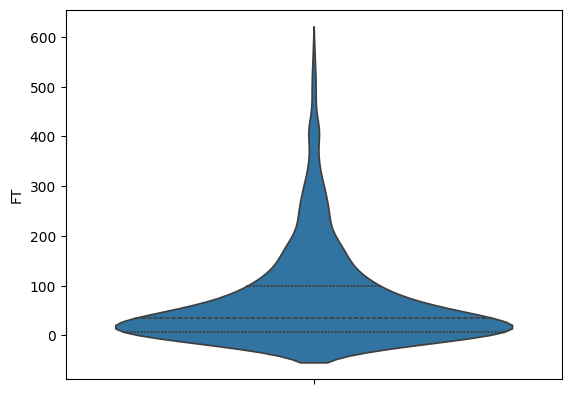

In [16]:
# visualizing data
sns.violinplot(data.FT,inner='quart')

Without sperating positions, the graph has a normal skew. While this model does work, I want to see if I can create a model with less divergences.

In [32]:
with pm.Model(coords = bask_coords) as bask_model:

    μ_mu = pm.Normal('μ_mu', mu = 0, sigma = 300)
    μ_sd = pm.HalfNormal('μ_sd', sigma = 30)


    μ = pm.Normal('μ',
                  mu = μ_mu,
                  sigma = μ_sd)

    σ = pm.HalfNormal('σ', sigma = 10)

    α = pm.Exponential('α', lam = 5)


    _ = pm.SkewNormal('trb', mu = μ, sigma = σ, alpha = α, observed = data.FT.values)


    idata_bask = pm.sample(target_accept = 0.95)

Output()

Output()

ERROR:pymc.stats.convergence:There were 146 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Output()

<Axes: xlabel='trb'>

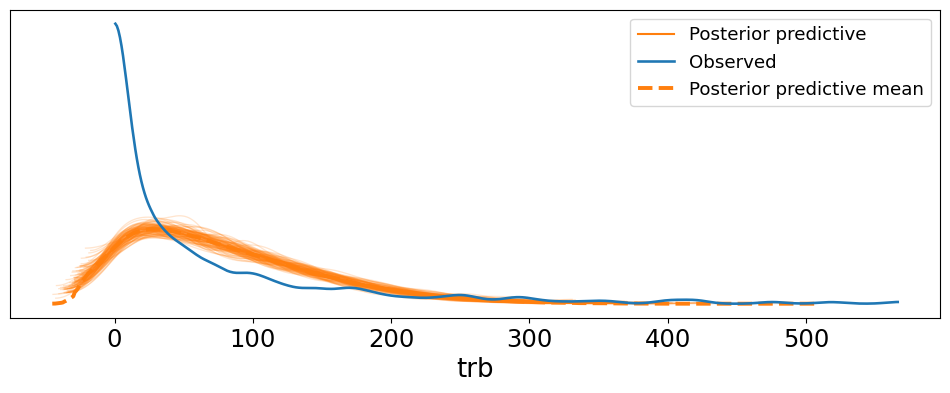

In [19]:
pm.sample_posterior_predictive(idata_bask, model=bask_model, extend_inferencedata=True)
az.plot_ppc(idata_bask, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])

After seeing this normal skew model, I decided to try an exponential model as thaat could fit the data better.

In [21]:
with pm.Model(coords = bask_coords) as bask_model:

    a = pm.Gamma('a', alpha = 1, beta = 1)
    b = pm.Gamma('b', alpha = 1, beta = 1)


    λ = pm.Gamma('λ', alpha = a, beta = b)


    _ = pm.Exponential('trb', lam = λ, observed = data.FT.values)


    idata_bask = pm.sample(target_accept = 0.95)

Output()

Output()

Output()

(0.0, 1100.0)

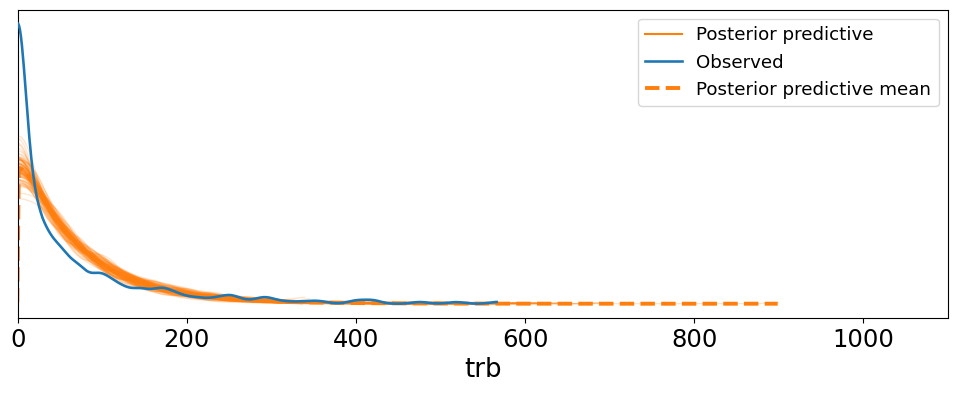

In [22]:
pm.sample_posterior_predictive(idata_bask, model=bask_model, extend_inferencedata=True)
ax = az.plot_ppc(idata_bask, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])
ax.set_xlim(0, 1100)

This model looks like a better fit for the data. Now, I'm gonna seperate the posterior by position to get more information out of the data.

In [24]:
with pm.Model(coords = bask_coords) as bask_model:

    a = pm.Gamma('a', alpha = 1, beta = 1)
    b = pm.Gamma('b', alpha = 1, beta = 1)


    λ = pm.Gamma('λ', alpha = a, beta = b, dims = "pos")


    _ = pm.Exponential('trb', lam = λ[pos_idx], observed = data.FT.values)


    idata_bask = pm.sample(target_accept = 0.95)

Output()

Output()

# Analysis

I created trace plots for the parameters of the inference data object, limiting the x-axis for λ to improve readability. These plots, separated by position for the exponential model, show that some positions have clear peaks, while others are flatter and more dispersed. This pattern will also appear in the forest plot.

(0.0, 0.015)

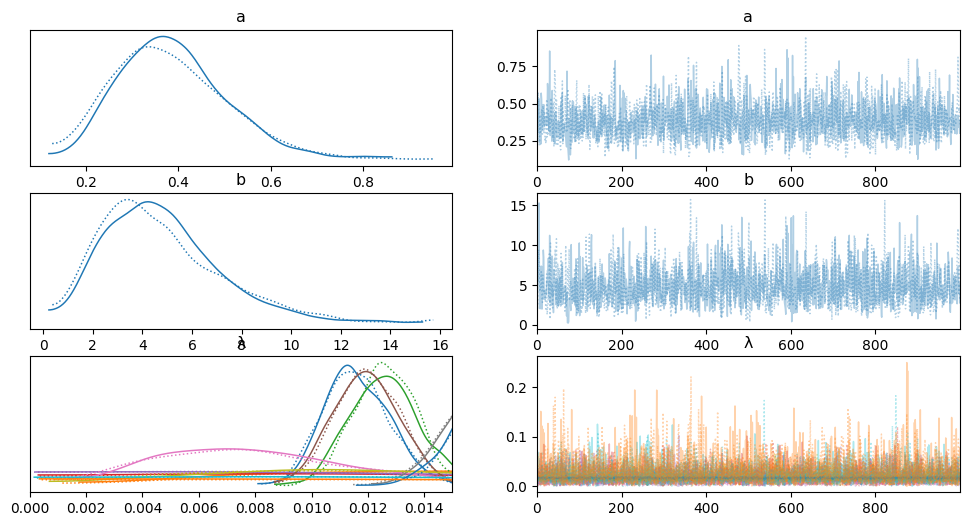

In [25]:

az.plot_trace(idata_bask)[2,0].set_xlim([0, .015])

The values above look almost perfectly mathced to the models.

In [26]:
az.rhat(idata_bask)

<xarray.Dataset> Size: 352B
Dimensions:  (pos: 12)
Coordinates:
  * pos      (pos) <U5 240B 'C' 'C-PF' 'PF' 'PF-C' ... 'SF-SG' 'SG' 'SG-PG'
Data variables:
    a        float64 8B 1.003
    b        float64 8B 1.001
    λ        (pos) float64 96B 1.002 1.0 1.002 1.001 1.0 ... 1.002 1.0 1.0 1.001

Below is the forest plot of λ by position. The reciprocal of this model will act as the final prediction.

array([<Axes: >], dtype=object)

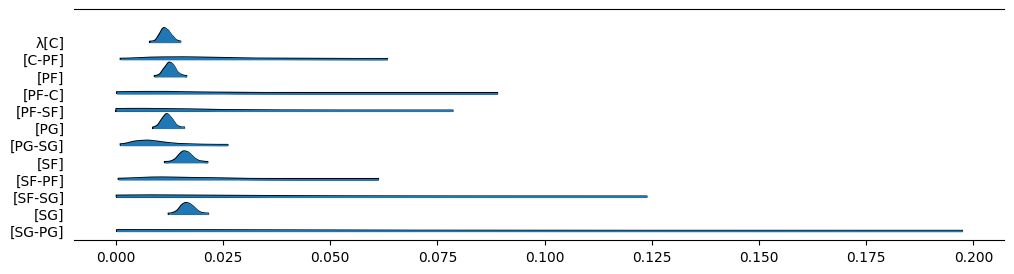

In [27]:
az.plot_forest(idata_bask, var_names=['λ'], combined=True, figsize=(12, 3), kind = 'ridgeplot', hdi_prob=0.998)

The code below takes the means of the lambda values and finds the reciprocal  of each position.

In [28]:


posterior = idata_bask.posterior
lambda_variable = posterior['λ']
mean_lambda = lambda_variable.mean(dim=['chain', 'draw'])
mean_array = mean_lambda.values



reciprocal_array = []
for value in mean_array:
    reciprocal = 1 / value
    reciprocal_array.append(reciprocal)


for i in range(len(pos_codes)):
    position = pos_codes[i]
    reciprocal = reciprocal_array[i]
    print(f'{position}: {reciprocal}')

C: 86.19134388086304
C-PF: 53.16650807719877
PF: 79.29051964029291
PF-C: 52.750521201721476
PF-SF: 64.4986220386121
PG: 83.46526734717895
PG-SG: 116.78499619385806
SF: 61.54035540862145
SF-PF: 60.044012148925134
SF-SG: 40.64012992070773
SG: 60.09901772380606
SG-PG: 28.130744908926687


<BarContainer object of 12 artists>

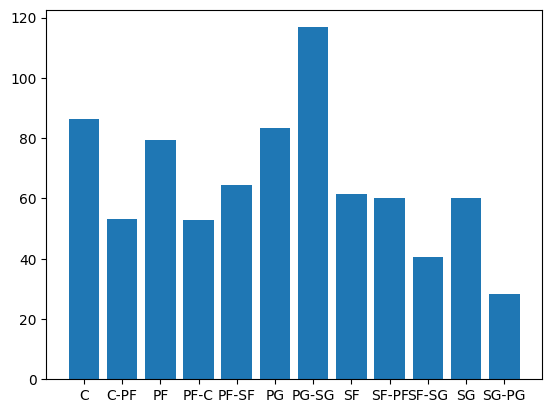

In [33]:
plt.bar(pos_codes, reciprocal_array)

This is a bar graph visualizing the model.

# Conclusion

Point guards and shooting guards usually shoot the most free throws on the team as they are usually the ones who are fouled. It is worth noting that centers are also fouled frequently as being under the beasket requires a physical style of play. While they have a lot of volume in free throw shooting, the position is regarded as the worst at shooting free throws on a team.